In [83]:
import sys
import os

In [84]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from ipywidgets import interactive, IntSlider
from brokenaxes import brokenaxes

import numpy as np
import pandas as pd
import sqlite3
import torch

In [85]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

In [86]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [87]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [88]:
WL_COLUMNS = ['empty_reads', 'non_empty_reads', 'range_queries', 'writes']
SYS_COLUMNS = ['entry_size', 'selectivity', 'entries_per_page', 'num_elmement', 'bits_per_elem_max', 'read_write_asym']

In [89]:
klsm_con = sqlite3.connect("/scratchNVMe/axe/db/exp090924_100trials.db")
kcursor = klsm_con.cursor()

In [90]:
ylsm_con = sqlite3.connect("/scratchNVMe/axe/db/yzlsm/mlos_exp_yz.db")
ycursor = ylsm_con.cursor()

In [91]:
clsm_con = sqlite3.connect("/scratchNVMe/axe/db/classic/mlos_exp_classic.db")
ccursor = clsm_con.cursor()

In [92]:
def get_tables(connection):
    env_table = pd.read_sql("SELECT * FROM environments;", connection, index_col="env_id")
    run_table = pd.read_sql("SELECT * FROM tunings;", connection, index_col="idx")
    ltune_table = pd.read_sql("SELECT * FROM learned_tunings;", connection, index_col="env_id")

    return env_table, run_table, ltune_table

ktables = get_tables(klsm_con)
ytables = get_tables(ylsm_con)
ctables = get_tables(clsm_con)

In [93]:
def get_data(env_id, tables):
    env_table, run_table, ltune_table = tables
    env = env_table.query(f'env_id == {env_id}')
    data = run_table.query(f'env_id == {env_id}')
    learned_tuning = ltune_table.query(f'env_id == {env_id}')
    wl = Workload(*env[WL_COLUMNS].values[0])
    system = System(*env[SYS_COLUMNS].values[0])
    ltune_cost = learned_tuning.cost.values[0]
    
    group = run_table.query(f'env_id == {env_id}').groupby("round")['cost'].agg(['mean', 'std', 'count'])
    group = group.reset_index()
    group['ci'] = 1.96 * group['std'] / np.sqrt(group['count'])
    group['ci_lower'] = group['mean'] - group['ci']
    group['ci_upper'] = group['mean'] + group['ci']
    group['ltune_cost'] = ltune_cost

    return group, wl, system, ltune_cost

In [94]:
def plot_env(env_id, tables):
    group, wl, system, ltune_cost = get_data(env_id, tables)
    
    fig, ax = plt.subplots()
    ax.plot(group['round'], group['mean'], label='Bayesian Optimizer', color='tab:gray', marker='o')
    ax.fill_between(group['round'], group['ci_lower'], group['ci_upper'], color='tab:gray', alpha=.25)
    ax.hlines(y=ltune_cost, xmin=0, xmax=group['round'].values.max(), label='LTune', color='tab:green', linestyle='--')
    ax.legend()
    ax.set_ylabel('Estimate Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload(z0={wl.z0:.2f}, z1={wl.z1:.2f}, q={wl.q:.2f}, w={wl.w:.2f})')
    plt.show()

    return env_id, wl, system, fig, ax

In [95]:
group, wl, system, ltune_cost = get_data(1, ctables)

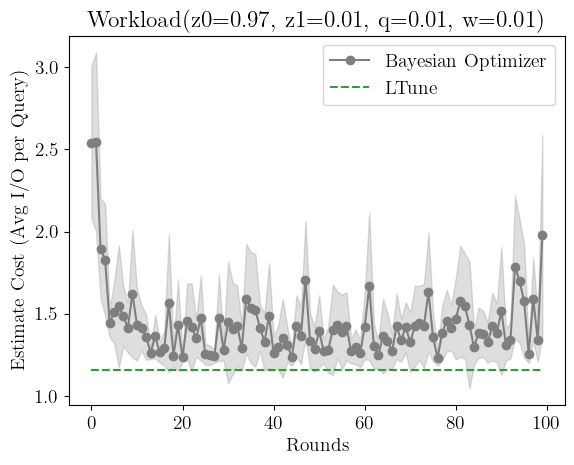

(2,
 Workload(z0=0.97, z1=0.01, q=0.01, w=0.01),
 System(E=8192.0, s=4e-07, B=4.0, N=1000000000.0, H=10.0, phi=1.0),
 <Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Workload(z0=0.97, z1=0.01, q=0.01, w=0.01)'}, xlabel='Rounds', ylabel='Estimate Cost (Avg I/O per Query)'>)

In [96]:
plot_env(2, ctables)

In [97]:
tables = ctables
id_widget = IntSlider(min=1, max=len(tables[0]), step=1)
iplot_env = interactive(lambda id: plot_env(id, tables), id=id_widget)
iplot_env

interactive(children=(IntSlider(value=1, description='id', max=15, min=1), Output()), _dom_classes=('widget-in…

In [98]:
def get_cdf_data(tables, window_size=1):
    env_table, run_table, ltune_table = tables
    data = []
    for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
        valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
                         .rolling(window_size).min().fillna(0) \
                         .to_numpy().nonzero()[0]
        data.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])

    return data

In [99]:
window_size = 3
klsm_cdf = get_cdf_data(ktables, window_size=window_size)
ylsm_cdf = get_cdf_data(ytables, window_size=window_size)
clsm_cdf = get_cdf_data(ctables, window_size=window_size)

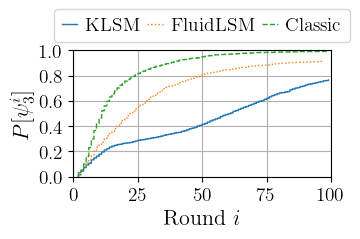

In [100]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(1*width, 0.8*height))

ax.ecdf(klsm_cdf, label='KLSM', complementary=False, rasterized=True, linewidth=1, linestyle='-')
ax.ecdf(ylsm_cdf, label='FluidLSM', complementary=False, rasterized=True, linewidth=1, linestyle='dotted')
ax.ecdf(clsm_cdf, label='Classic', complementary=False, rasterized=True, linewidth=1, linestyle='--')
    
ax.set_xlabel("Round $i$", fontsize=16)
ax.set_ylabel(r"$P[ \psi_3^i ]$", fontsize=16)
ax.set_xlim([0, 100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0, 1])
ax.legend(loc='upper center', labelspacing=0.3, columnspacing=0.4, handlelength=0.8, handletextpad=0.4, ncol=3, bbox_to_anchor=(0.5, 1.40))
ax.grid()
plt.show()
save_fig(fig, 'bo_cdf_designs.pdf')